In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandasql as ps
import statsmodels.stats.multicomp as mc

pysqldf = lambda q: ps.sqldf(q, globals())

# Read and transform data sets

In [3]:
# full data set is about 6*10^6 rows, so we can afford to omit the ones that are missing values for any reason
        # according to FracFocus's Terms of Use agreement, any disclosures submitted with FracFocus version 1 (i.e. before 2013) will be missing data
        # so this action excludes all wells from before 2012 and some from 2013, when the version changed
naCSV = pd.read_csv("..\data\processedRegistry.csv")
regCSV0 = pd.read_csv("..\data\processedRegistry.csv").dropna()

# remove 205 rows with impossible numerical values
regQry = """SELECT * 
FROM regCSV0
WHERE depth >= 0 AND waterVol >= 0 AND nonWaterVol >= 0 AND PercentHFJob >= 0 AND MassIngredient >= 0 AND jobYear < 2025"""
regCSV = pysqldf(regQry)

# each job's disclosed chemical(s) are on their own lines due to tidy data principles
    # so, to determine how many jobs have been disclosed, keep only the first instance of that job and get rid of the rest
wellsCSV = regCSV.drop_duplicates(subset = (["APINumber", "jobYear"]), keep = "first") # subset by both APINumber and jobYear because some of the wells (identified by API number) can complete multiple jobs across different years
        
statesCts = wellsCSV["state"].value_counts().reset_index().rename(columns = {"index" : "state", "state" : "count"})
#statesCts.to_csv("statesCts.csv")

C:\Users\phoeb\AppData\Local\Temp\ipykernel_13580\1397513058.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  naCSV = pd.read_csv("..\data\processedRegistry.csv")
C:\Users\phoeb\AppData\Local\Temp\ipykernel_13580\1397513058.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  regCSV0 = pd.read_csv("..\data\processedRegistry.csv").dropna()


# Summary statistics and data exploration

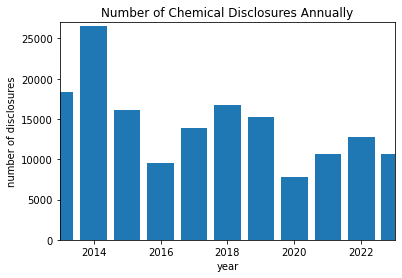

In [26]:
yrsCts = wellsCSV["jobYear"].dropna().value_counts().reset_index().rename(columns = {"index" : "year", "jobYear" : "count"}).astype(int)
#yrsCts.to_csv("yrsCts.csv")

plt.bar(yrsCts["year"], yrsCts["count"])

plt.xlabel("year")
plt.ylabel("number of disclosures")
plt.title("Number of Chemical Disclosures Annually")

plt.ylim(0, 27000)
plt.xlim(2013, 2023)

plt.show()

In [5]:
numCols = ["jobYear", "depth", "waterVol", "nonWaterVol", "PercentHFJob", "MassIngredient"]
catCols = ["APINumber", "state", "op", "WellName", "CASNumber"]

In [27]:
numColsList = []
for clmn in numCols:
    numColsList.append(list(wellsCSV[clmn].describe()))
numColsDF = pd.DataFrame(numColsList, columns = ["count", "mean", "std", "min", "Q1", "median", "Q3", "max"], index = [numCols])

#numColsDF.to_csv("numColsDF.csv")

numColsDF

,count,mean,std,min,Q1,median,Q3,max
jobYear,159528.0,2.017247e+03,3.223093e+00,2001.0,2.014000e+03,2.017000e+03,2.020000e+03,2.024000e+03
depth,159528.0,1.949045e+04,3.051346e+06,0.0,6.969000e+03,8.852000e+03,1.076300e+04,1.185012e+09
waterVol,159528.0,9.355072e+06,8.950311e+06,0.0,1.889342e+06,7.265188e+06,1.480071e+07,4.724441e+08
nonWaterVol,159528.0,1.156295e+05,9.017314e+06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.508722e+09
PercentHFJob,159528.0,8.786791e+00,2.491648e+01,0.0,5.840246e-04,6.148097e-03,9.223344e-02,1.000000e+02
MassIngredient,159528.0,7.988627e+06,2.002671e+08,0.0,2.709850e+00,7.829597e+02,2.158003e+04,4.360990e+10


In [7]:
catColsList = []
for clmn in catCols:
    catColsList.append(list(wellsCSV[clmn].describe()))
catColsDF = pd.DataFrame(catColsList, columns = ["count", "unique", "top", "freq"], index = [catCols])

catColsDF

,count,unique,top,freq
APINumber,159528,157336,35019045460000,4
state,159528,27,Texas,78087
op,159528,1668,"EOG Resources, Inc.",7284
WellName,159528,158360,Anderson 2H,4
CASNumber,159528,1066,7732-18-5,24538


# H1: Perform chi-square analysis to look for relationship between region and type of chemical used

- H0 = There is no relationship between well region and type of chemical used.
- Ha = There is a relationship between well region and type of chemical used.
- a = 0.05

In [8]:
## count frequency of chemicals and average amount used in a job by state

qry0 = """SELECT state, CASNumber, COUNT(CASNumber) as count, AVG(MassIngredient) AS avgAmnt
FROM (SELECT state, CASNumber, MassIngredient
      FROM regCSV)
GROUP BY CASNumber"""

chemCtsAmnt = pysqldf(qry0)

In [9]:

"""CASNumber column contains many typos and transcription errors, so we want to do 
    some tidying to get a clearer, more representitive picture of what's going on"""

chemCtsAmnt["CASNumber"] = chemCtsAmnt["CASNumber"].astype("string").str.replace("-", "")
chemCtsAmnt["CASNumber"] = chemCtsAmnt["CASNumber"].astype("string").str.replace("'", "")

# turn everything into integers and get rid of null values
chemCtsAmnt["CASNumber"] = pd.to_numeric(chemCtsAmnt["CASNumber"], errors = "coerce")
chemCtsNA = chemCtsAmnt.dropna()
chemCtsNA["CASNumber"] = chemCtsNA["CASNumber"].astype("int")

# select only entries that have valid CAS numbers (minimum 5 digits, maximum 10 digits)
qry2 = """SELECT state, CASNumber, count, avgAmnt
FROM chemCtsNA
WHERE LENGTH(CASNumber) > 4 AND LENGTH(CASNumber) < 11"""
chemCts2 = pysqldf(qry2)
        # note: some entries in CASNumber were name of them chemical so, even though the chemical was
        #   actually disclosed, it ended up ommitted from this table 


C:\Users\phoeb\AppData\Local\Temp\ipykernel_13580\1099184566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemCtsNA["CASNumber"] = chemCtsNA["CASNumber"].astype("int")


In [10]:
## regional categorization

sts = pd.read_csv("US census bureau regions - states.csv").set_index("state")
stsCol = regCSV["state"].copy()

# perform string transformations to tokenize state column
stsCol = stsCol.str.lower()
regCSV["state"] = stsCol

# initialize new list for categorizing state by region column
stCat = []

# fetch categorization information
states = list(regCSV["state"])

# populate region column with subregions as defined by the US Census Bureau
for i in range(len(regCSV["state"])):
    cat = sts.loc[states[i], "subregion"]
    stCat.append(cat)
    
# append new column to dataframe
regCSV["region"] = stCat

In [11]:
tabBase = regCSV.copy()

tabBase["CASNumber"] = tabBase["CASNumber"].str.replace("-", "")
tabBase["CASNumber"] = tabBase["CASNumber"].str.replace("'", "")

# turn everything into integers and get rid of null values
tabBase["CASNumber"] = pd.to_numeric(tabBase["CASNumber"], errors = "coerce")
tabBase = tabBase.dropna()
tabBase["CASNumber"] = tabBase["CASNumber"].astype("int") 

# select only records that contain valid CAS numbers
tabQry = """SELECT state, region, CASNumber
FROM tabBase
WHERE LENGTH(CASNumber) > 4 AND LENGTH(CASNumber) < 11"""
tabBaseDF = pysqldf(tabQry)
tabBaseDF


,state,region,CASNumber
0,ohio,e n central,68551122
1,ohio,e n central,104552
2,ohio,e n central,7732185
3,ohio,e n central,7173515
4,ohio,e n central,107211
...,...,...,...
4514823,texas,w s central,77929
4514824,texas,w s central,7173515
4514825,texas,w s central,111308
4514826,texas,w s central,64175


In [12]:
# 1. create contingency table
conTab = pd.crosstab(index = tabBaseDF["region"], columns = tabBaseDF["CASNumber"], values = tabBaseDF["CASNumber"], aggfunc = "count", margins = True)
cT2 = conTab.fillna(0)

# 2. run analysis
res = stats.chi2_contingency(cT2)

# 3. report and interpret results
print("Test statistic: " + str(res[0]))
    # Test statistic: 2042505.9345184155
print("p-value: " + str(res[1]))
    # p-value: 2.5353699709821727e-123
print("Degrees of freedom: " + str(res[2]))
    # Degrees of freedom: 15216
    
    # p ≈ 0, a = 0.05
    # p < a, therefore we reject the null hypothesis in favor of the alternative:
        # There does indeed exist a relationship between types of chemicals used and region.

Test statistic: 2042377.0076372474
p-value: 0.0
Degrees of freedom: 15216


# H2: Perform chi-square on chemicals based on average volume of each type of chemical and region

- H0 = There is no relationship between average volume of chemical type and well region.
- Ha = There is a relationship between average volume of chemical type and well region.
- a = 0.05

In [29]:
# perform string transformations to tokenize Purpose column
purp = regCSV["Purpose"].str.lower()
purp = purp.str.replace(" ", "")
    # 3511 unique values -> 2785 unique values
# export unique values and manually categorize 
    # could not be algorithmically categorized due to spelling errors, unspecific/inaccurate descriptions, etc.
# pd.DataFrame(purp.unique()).to_csv("purpp.csv")

In [40]:
# initialize new column for categorization of chemicals
purpCat = []

# fetch categorization reference list
prp = pd.read_csv("purpp.csv").set_index("current")
prp["replaceWith"] = prp["replaceWith"].str.strip()
purposes = list(regCSV["Purpose"])

# populate new column
for i in range(len(regCSV["Purpose"])):
    try:
        cat = prp.loc[purposes[i], "replaceWith"]
        purpCat.append(cat)
    except:
        purpCat.append("nan")

# append new column to dataset
regCSV["purpCat"] = purpCat

# use new tokenized and cleaned purpose column so the replacement can happen properly
regCSV["Purpose"] = purp

In [41]:
## complete analysis

# 1. create contingency table
conTab2 = pd.crosstab(index = regCSV["region"], columns = regCSV["purpCat"], values = regCSV["PercentHFJob"], aggfunc = "mean", margins = True)
conTab2 = conTab2.fillna(0)

# 2. run analysis
res2 = stats.chi2_contingency(conTab2)

# 3. report and interpret results
print("Test statistic: " + str(res2[0]))
    # Test statistic: 60.013141569569335
print("p-value: " + str(res2[1]))
    # p-value: 0.9999999999413731 
print("Degrees of freedom: " + str(res2[2]))
    # Degrees of freedom: 144

    # p = 0.999
    # a = 0.05
    # p > a, therefore we fail to reject the null hypothesis.
    # There is no statistically significant relationship between average volume of each chemical type and region.

Test statistic: 60.013141569569335
p-value: 0.9999999999413731
Degrees of freedom: 144


# H3: ANOVA to test significance of relationship between numerical well characteristics and region, top 10 most prolific well operators

- H0: There is no difference in means of each of these groups.
- Ha: At least one of the means of these groups differs from the others.

In [55]:
## add region column to data frame
stsCol2 = wellsCSV["state"].copy()
# perform string transformations to tokenize state column
stsCol2 = stsCol2.str.lower()
wellsCSV["state"] = stsCol2
# initialize new list for categorizing state by region column
stCat2 = []
# fetch categorization information
states2 = list(wellsCSV["state"])
# populate region column with subregions as defined by the US Census Bureau
for i in range(len(wellsCSV["state"])):
    cat = sts.loc[states2[i], "subregion"]
    stCat2.append(cat)
# append new column to dataframe
wellsCSV["region"] = stCat2

C:\Users\phoeb\AppData\Local\Temp\ipykernel_13580\1708868204.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wellsCSV["state"] = stsCol2
C:\Users\phoeb\AppData\Local\Temp\ipykernel_13580\1708868204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wellsCSV["region"] = stCat2


In [56]:
### determine most prolific well operators
qry3 = """SELECT op, COUNT(jobYear) AS numJobs
FROM wellsCSV
GROUP BY op
ORDER BY numJobs DESC
LIMIT 10"""
opDF = pysqldf(qry3)

opDF.to_csv("wellOps.csv")

In [46]:
### numeric continuous columns:
    # depth
    # waterVol
### categorical columns:
    # op
    # region
    
### assumptions:
    # independence: all of the wells are operated by a single operator and exist in a single location, so this condition is satisfied
    # normality: data set is large enough to assume normality
    # equal variances: data set is large enough to assume equal variances
    
depthOp = list(stats.f_oneway(wellsCSV["depth"][wellsCSV["op"] == 'EOG Resources, Inc.'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Anadarko Petroleum Corporation'],
                   wellsCSV["depth"][wellsCSV["op"] == 'XTO Energy/ExxonMobil'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Chesapeake Operating, Inc.'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Pioneer Natural Resources'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Devon Energy Production Company L. P.'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Occidental Oil and Gas'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Marathon Oil'],
                   wellsCSV["depth"][wellsCSV["op"] == 'ConocoPhillips Company/Burlington Resources'],
                   wellsCSV["depth"][wellsCSV["op"] == 'Apache Corporation']))

waterVolOp = list(stats.f_oneway(wellsCSV["waterVol"][wellsCSV["op"] == 'EOG Resources, Inc.'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Anadarko Petroleum Corporation'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'XTO Energy/ExxonMobil'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Chesapeake Operating, Inc.'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Pioneer Natural Resources'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Devon Energy Production Company L. P.'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Occidental Oil and Gas'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Marathon Oil'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'ConocoPhillips Company/Burlington Resources'],
                   wellsCSV["waterVol"][wellsCSV["op"] == 'Apache Corporation']))

depthRegion = list(stats.f_oneway(wellsCSV["depth"][wellsCSV["region"] == 'e n central'],
                   wellsCSV["depth"][wellsCSV["region"] == 'w s central'],
                   wellsCSV["depth"][wellsCSV["region"] == 'middle atlantic'],
                   wellsCSV["depth"][wellsCSV["region"] == 'w n central'],
                   wellsCSV["depth"][wellsCSV["region"] == 'mountain'],
                   wellsCSV["depth"][wellsCSV["region"] == 's atlantic'],
                   wellsCSV["depth"][wellsCSV["region"] == 'e s central'],
                   wellsCSV["depth"][wellsCSV["region"] == 'pacific']))

waterVolRegion = list(stats.f_oneway(wellsCSV["waterVol"][wellsCSV["region"] == 'e n central'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'w s central'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'middle atlantic'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'w n central'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'mountain'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 's atlantic'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'e s central'],
                   wellsCSV["waterVol"][wellsCSV["region"] == 'pacific']))

In [47]:
# create DataFrame of results
TESTS = [depthOp, waterVolOp, depthRegion, waterVolRegion]
clmns = ["statistic", "p-value"]

anovasDF = pd.DataFrame(TESTS, columns = clmns)
anovasDF["test"] = ["depthOp", "waterVolOp", "depthRegion", "waterVolRegion"]
anovasDF.set_index("test", inplace = True)

In [48]:
anovasDF

,statistic,p-value
test,,
depthOp,7.515004,4.514892e-11
waterVolOp,575.258355,0.000000e+00
depthRegion,0.129881,9.961637e-01
waterVolRegion,1381.641863,0.000000e+00


In [57]:
# save final modified registry as csv for easy future reference
regCSV.to_csv("reg2.csv")

## Conduct post hoc test to determine which pairs are the significantly different ones

### Tukey HSD Test for Hypothesis I

### Tukey HSD Test for Hypothesis II

### Tukey HSD Test for Hypothesis III

In [60]:
# create data frame with only operators we want for Tukey HSD test
tukeyQryIII = """SELECT op, region, depth, waterVol 
FROM wellsCSV 
WHERE op = 'EOG Resources, Inc.' OR op = 'Anadarko Petroleum Corporation' OR op = 'XTO Energy/ExxonMobil' OR op = 'Chesapeake Operating, Inc.' OR op = 'Pioneer Natural Resources' OR op = 'Devon Energy Production Company L. P.' OR op= 'Occidental Oil and Gas' OR op = 'Marathon Oil' OR op = 'ConocoPhillips Company/Burlington Resources' OR op = 'Apache Corporation'"""

tukeyDFIII = pysqldf(tukeyQryIII)

# save tukeyDFIII as csv for R visualizatons
tukeyDFIII.to_csv("tkDF3.csv")

In [64]:
"""
'ConocoPhillips Company/Burlington Resources' --> CON
      'Devon Energy Production Company L. P.' --> DEV
             'Anadarko Petroleum Corporation' --> ANA
                 'Chesapeake Operating, Inc.' --> CHE
                         'Apache Corporation' --> APA
                        'EOG Resources, Inc.' --> EOG
                  'Pioneer Natural Resources' --> PIO
                      'XTO Energy/ExxonMobil' --> XTO
                     'Occidental Oil and Gas' --> OCC
                               'Marathon Oil' --> MAR
"""

CON = tukeyDFIII[tukeyDFIII["op"] == 'ConocoPhillips Company/Burlington Resources']
DEV = tukeyDFIII[tukeyDFIII["op"] == 'Devon Energy Production Company L. P.']
ANA = tukeyDFIII[tukeyDFIII["op"] == 'Anadarko Petroleum Corporation']
CHE = tukeyDFIII[tukeyDFIII["op"] == 'Chesapeake Operating, Inc.']
APA = tukeyDFIII[tukeyDFIII["op"] == 'Apache Corporation']
EOG = tukeyDFIII[tukeyDFIII["op"] == 'EOG Resources, Inc.']
PIO = tukeyDFIII[tukeyDFIII["op"] == 'Pioneer Natural Resources']
XTO = tukeyDFIII[tukeyDFIII["op"] == 'XTO Energy/ExxonMobil']
OCC = tukeyDFIII[tukeyDFIII["op"] == 'Occidental Oil and Gas']
MAR = tukeyDFIII[tukeyDFIII["op"] == 'Marathon Oil']

In [ ]:
# run test on depth/operator pairs
depthOpRes = mc.MultiComparison(tukeyDF["depth"], tukeyDF["op"])
depthOpTky = depthOpRes.tukeyhsd()
doTky = depthOpTky.summary() # create silly little simpletable object that is not simple and barely functions as a table
#pd.DataFrame(doTky).to_csv("do.csv")
# manually go in and remove erroneous row and column
doDF = pd.read_csv("do.csv")

# select only pairs where we reject the null hypothesis
doDF2 = doDF[doDF["reject"]]
doDF2


,group1,group2,meandiff,p-adj,lower,upper,reject
2,Anadarko Petroleum Corporation,ConocoPhillips Company/Burlington Resources,1505.5161,0.0339,57.3014,2953.7307,True
4,Anadarko Petroleum Corporation,"EOG Resources, Inc.",1507.0543,0.0012,369.2598,2644.8488,True
5,Anadarko Petroleum Corporation,Marathon Oil,1869.5442,0.0011,460.5774,3278.5110,True
10,Apache Corporation,ConocoPhillips Company/Burlington Resources,1735.7222,0.0302,84.3907,3387.0538,True
12,Apache Corporation,"EOG Resources, Inc.",1737.2605,0.0030,350.1243,3124.3966,True
13,Apache Corporation,Marathon Oil,2099.7503,0.0016,482.7291,3716.7716,True
17,"Chesapeake Operating, Inc.",ConocoPhillips Company/Burlington Resources,2047.8961,0.0004,579.7628,3516.0293,True
19,"Chesapeake Operating, Inc.","EOG Resources, Inc.",2049.4343,0.0000,886.3926,3212.4760,True
20,"Chesapeake Operating, Inc.",Marathon Oil,2411.9242,0.0000,982.4917,3841.3566,True
30,Devon Energy Production Company L. P.,"EOG Resources, Inc.",1517.9576,0.0074,229.9027,2806.0125,True


In [ ]:

# run test on water volume/operator pairs
volOpTky = mc.MultiComparison(tukeyDF["waterVol"], tukeyDF["op"]).tukeyhsd().summary()
#pd.DataFrame(volOpTky).to_csv("vo.csv")

# manually go in and remove erroneous row and column
voDF = pd.read_csv("vo.csv")

# select only pairs where we reject the null hypothesis
voDF2 = voDF[voDF["reject"]]
voDF2

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Anadarko Petroleum Corporation,"Chesapeake Operating, Inc.",5.946052e+05,0.0015,1.395529e+05,1.049658e+06,True
4,Anadarko Petroleum Corporation,"EOG Resources, Inc.",4.147598e+06,0.0000,3.730333e+06,4.564863e+06,True
7,Anadarko Petroleum Corporation,Pioneer Natural Resources,7.178849e+06,0.0000,6.709160e+06,7.648538e+06,True
8,Anadarko Petroleum Corporation,XTO Energy/ExxonMobil,4.247855e+06,0.0000,3.797125e+06,4.698584e+06,True
9,Apache Corporation,"Chesapeake Operating, Inc.",1.089286e+06,0.0000,5.491517e+05,1.629419e+06,True
11,Apache Corporation,Devon Energy Production Company L. P.,9.638330e+05,0.0000,3.868101e+05,1.540856e+06,True
12,Apache Corporation,"EOG Resources, Inc.",4.642278e+06,0.0000,4.133572e+06,5.150984e+06,True
13,Apache Corporation,Marathon Oil,6.570706e+05,0.0165,6.405863e+04,1.250083e+06,True
15,Apache Corporation,Pioneer Natural Resources,7.673529e+06,0.0000,7.121008e+06,8.226050e+06,True
16,Apache Corporation,XTO Energy/ExxonMobil,4.742535e+06,0.0000,4.206038e+06,5.279032e+06,True


In [ ]:
# run test on water volume/region pairs
volRgnTky = mc.MultiComparison(tukeyDF["waterVol"], tukeyDF["region"]).tukeyhsd().summary()
#pd.DataFrame(volRgnTky).to_csv("vr.csv")

# manually go in and remove erroneous row and column
vrDF = pd.read_csv("vr.csv")

# select only pairs where we reject the null hypothesis
vrDF2 = vrDF[vrDF["reject"]]
vrDF2


,group1,group2,meandiff,p-adj,lower,upper,reject
3,e n central,pacific,-8.458022e+06,0.0000,-1.008220e+07,-6.833846e+06,True
5,e n central,w n central,-2.723961e+06,0.0000,-3.712661e+06,-1.735260e+06,True
6,e n central,w s central,9.574948e+05,0.0260,6.299940e+04,1.851990e+06,True
13,middle atlantic,mountain,-1.022963e+06,0.0013,-1.786294e+06,-2.596324e+05,True
14,middle atlantic,pacific,-9.412179e+06,0.0000,-1.095571e+07,-7.868649e+06,True
16,middle atlantic,w n central,-3.678117e+06,0.0000,-4.527859e+06,-2.828375e+06,True
18,mountain,pacific,-8.389216e+06,0.0000,-9.772349e+06,-7.006082e+06,True
20,mountain,w n central,-2.655154e+06,0.0000,-3.157784e+06,-2.152524e+06,True
21,mountain,w s central,1.026301e+06,0.0000,7.520192e+05,1.300584e+06,True
22,pacific,s atlantic,9.790304e+06,0.0000,7.099221e+06,1.248139e+07,True
